<a href="https://colab.research.google.com/github/r-diazp/deepL/blob/master/02_ann_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![pytorch icon.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWyV5brHNCcNRsfWARFMR78N0Wg5V2hksMVYQeOpYnBn4zKOX2PPWky9wqxVoXuvnUi_s&usqp=CAU)


# Librerias

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

import time
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Cargar datos y limpieza

In [2]:
#Revisar si la GPU esta habilitda y modelo 
print(f'- GPU available: {torch.cuda.is_available()} \
      \n- GPU: {torch.cuda.get_device_name(0)}')

- GPU available: True       
- GPU: Tesla T4


In [17]:
path = '/content/drive/MyDrive/Dataset/'
df = pd.read_csv(path + 'income.csv')
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
#FEACTURE SPLIT
#Separar las variables categoricas y continuas 
categorical_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
continuous_cols = ['age', 'hours-per-week']
#Target
target = ['label']  #Esta columna contiene la var,iable a predecir 

# RUN THIS CODE TO COMPARE RESULTS:
print(f'categorical_cols  tiene {len(categorical_cols)} columnas')
print(f'continuous_cols tiene {len(continuous_cols)} columnas')
print(f'target tiene {len(target)} columnas')

categorical_cols  tiene 5 columnas
continuous_cols tiene 2 columnas
target tiene 1 columnas


In [5]:
#CATEGORICAL FEACTURE
#Categorizar
for categorical in categorical_cols:
    df[categorical] = df[categorical].astype('category')

#Matriz con las categorias 
sex = df['sex'].cat.codes.values
education = df['education'].cat.codes.values
marital_status = df['marital-status'].cat.codes.values
workclass = df['workclass'].cat.codes.values
occupation = df['occupation'].cat.codes.values
array_categorical = [sex, education, marital_status, workclass, occupation]

#Convertir las variables cateogricas en tensores en la GPU
categories_tensor = np.stack(array_categorical, axis=1) #stack unimos las matrices
categories_tensor = torch.tensor(categories_tensor, dtype=torch.int64).cuda()
categories_tensor[:]

#EMBEDDING CATEGORICAL COLUMN
categorical_size = [len(df[col].cat.categories) for col in categorical_cols] #Total de categorias por columna en cat_cols
embedding_size = [(size, min(50, (size+1)//2) ) for size in categorical_size]
print(f'- categorical_size: {categorical_size} \
      \n- embedding_size: {embedding_size} ')

#CONTINUOUS FEACTURE
#Convertir las variables continuas en tensores en la GPU
continuous_tensor = np.stack([df[col].values for col in continuous_cols], axis=1) # stack unimos las matrices
continuous_tensor = torch.tensor(continuous_tensor, dtype=torch.float).cuda()

#Convertir la variable a predecir en tensor en la GPU
target_tensor = torch.tensor(df[target].values).flatten().cuda()

#Imprimir resultados
print(f"\nTENSORS: \n- categories_tensor: {categories_tensor[:]} | cpu/gpu = {categories_tensor.device} \
      \n- continuous_tensor: {continuous_tensor[:]} | cpu/gpu = {continuous_tensor.device} \
      \n- target_tensor: {target_tensor[:]} | cpu/gpu = {target_tensor.device}") 

- categorical_size: [2, 14, 6, 5, 12]       
- embedding_size: [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)] 

TENSORS: 
- categories_tensor: tensor([[ 1, 10,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1, 10,  0,  3,  7],
        ...,
        [ 1, 12,  1,  2,  7],
        [ 0, 13,  3,  2,  0],
        [ 1,  6,  1,  3,  2]], device='cuda:0') | cpu/gpu = cuda:0       
- continuous_tensor: tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        ...,
        [47., 55.],
        [32., 40.],
        [33., 60.]], device='cuda:0') | cpu/gpu = cuda:0       
- target_tensor: tensor([0, 1, 0,  ..., 1, 0, 1], device='cuda:0') | cpu/gpu = cuda:0


In [6]:
#SPLIT DE LOS TENSORES 
batch_size = 30000
test_size = int(batch_size * .15 )

#Tensores de entranamiento 
categories_train = categories_tensor[:batch_size - test_size]
continuous_train = continuous_tensor[:batch_size - test_size]
target_train = target_tensor[:batch_size - test_size]

#Tensores de prueba 
categories_test = categories_tensor[batch_size - test_size:batch_size]
continuous_test = continuous_tensor[batch_size - test_size:batch_size]
target_test = target_tensor[batch_size - test_size:batch_size]

print(f'- row_train: {len(categories_train)} \n- row_test: {len(categories_test)}')

- row_train: 25500 
- row_test: 4500


# Arquitectura de la ANN

In [7]:
#@title
#Arquitectura de la Red Neuronal 
class Model(nn.Module):
  def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5): #constructor 
    super().__init__() #inicializa con los parametros de nn.Module
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(p) #Porcentaje de neuronas desabilitadas para evitar Overfitting
    self.bn_cont = nn.BatchNorm1d(n_cont) #https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html 
    
    layerlist = []
    n_emb = sum((nf for ni,nf in emb_szs)) #n_emb = 12+1+4=17 || emb_szs = [(24, 12), (2, 1), (7, 4)]
    n_in = n_emb + n_cont #n_cont = Columnas continuas: 6  || n_in = Numero columnas de entrada = 17+6
    
    #Arquitectura de la red neuronal
    for layer in layers:  
        layerlist.append(nn.Linear(n_in, layer))  #n_in=23 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(layer))
        layerlist.append(nn.Dropout(p))
        n_in = layer #n_in toma el valor del ultimo valor de la lista para conectar la capa oculta posterior 
    layerlist.append(nn.Linear(layers[-1], out_sz)) #Ultima capa oculta conectada a la Capa de salida             
    self.layers = nn.Sequential(*layerlist) # * = argumentos || https://realpython.com/python-kwargs-and-args/ 
      

  #funcion para la propagacion atras (Back propagation )
  def forward(self, x_cat, x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):  #propagacion para las variables categoricas 
        embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    
    x_cont = self.bn_cont(x_cont) #propagacion para las variables continuas 
    x = torch.cat([x, x_cont], 1)
    x = self.layers(x)
    return x


  #Funcion (metodo) para entrenar la red neuronal artificial 
  def train_model(self, x_cat, x_cont, y_train, criterion, optimizer, epochs = 100):
    self.criterion = criterion
    start_time = time.time()
    epochs = epochs
    losses = [] #resultados de la funcion de perdida 
    correct = 0

    for epoch in range(epochs):
      epoch+=1
      y_pred = self.forward(x_cat, x_cont)  #Se llama al metodo forward que habilita el Back Propagation
      loss =  self.criterion(y_pred, y_train) #Se calcula la funcion de perdida por cada epoca de entrenamiento
      losses.append(loss) #Se almacenan los resultados de la funcion de perdida en el array losses
                  
      if epoch%25 == 1:  #Mostrar avanaces cada 25 epocas 
        print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')                    

      optimizer.zero_grad() #Algoritmo para el entrenamiento (stochastic gradient descent) https://en.wikipedia.org/wiki/Stochastic_gradient_descent
      loss.backward() #Se propaga la funcion de perdida para ejuste de los pesos de la red neuronal 
      optimizer.step()

    #RESULTADOS DEL MODELO       
    for row in range(len(y_pred)):
      if y_pred[row].argmax().item() == y_train[row]:
        correct += 1
    print(f'{correct:,} de {len(y_train):,} correctas | Exactitud del modelo: {100*correct/len(y_train):.2f}% ')

    #Grafica de convergencia del entrenamiento 
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('Epocas');
    plt.grid(True)
   

    return losses, y_pred


  #Validar modelo con datos Test
  def test_validate(self, x_cat, x_cont, y_test, row_valid=0):
    correct = 0
    with torch.no_grad():
      y_pred = self.forward(x_cat, x_cont)
      loss = self.criterion(y_pred, y_test) 
    print(f'Loss: {loss:.8f}')
    
    for row in range(len(y_test) ):
      if y_pred[row].argmax().item() == y_test[row]:
        correct += 1
    print(f'{correct:,} de {len(y_test):,} correctas (Datos Tests) | Exactitud del modelo: {100*correct/len(y_test):.2f}% \n')

    if (row_valid) > 0:
      print(f'\n{"MODEL OUTPUT":50} REAL  Y_TEST')
      for i in range(row_valid):
        print(f'{str(y_pred[i]):50} {y_pred[i].argmax():^7}{y_test[i]:^7}')

In [8]:
#Instanciar modelo
#torch.manual_seed(33) #Opcional .. creamos una semilla para el proceso de entrenamiento de la red neuronal 
gpu_model = Model(embedding_size, continuous_tensor.shape[1], 2, [300,200], p=0.3).cuda()
#[500,400, 300] 3 capas ocultas con 500,400 y 200 neuronas respectivamente, se puede agregar o quitar mar extender el tamaño de la ANN 

#Definimos la funcion de perdida y el optimizador (stochastic gradient descent)
criterion = nn.CrossEntropyLoss() #Funcion de perdida 
optimizer = torch.optim.Adam(gpu_model.parameters(), lr=0.01) #Stochastic gradient descent (https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
print(f'- Model Arquitecture: {gpu_model} \n- Model is GPU(cuda): {next(gpu_model.parameters()).is_cuda}') #imprime arquitectura 


- Model Arquitecture: Model(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.3, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=200, out_features=2, bias=True)
  )
) 
- Model is GPU(cuda): True


epoch:   1 loss: 0.81686610
epoch:  26 loss: 0.33084261
epoch:  51 loss: 0.29369575
epoch:  76 loss: 0.27687955
epoch: 101 loss: 0.26767865
epoch: 126 loss: 0.26047516
epoch: 151 loss: 0.25818032
epoch: 176 loss: 0.25433031
epoch: 201 loss: 0.25124788
epoch: 226 loss: 0.25066671
epoch: 251 loss: 0.24878064
epoch: 276 loss: 0.24542513
22,596 de 25,500 correctas | Exactitud del modelo: 88.61% 


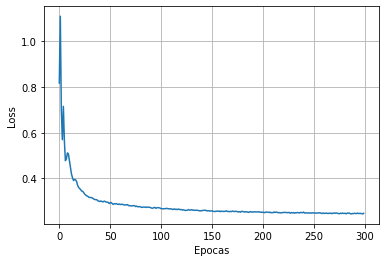

In [9]:
#Entrenar modelo 
epochs = 300
model_parameters = [categories_train, continuous_train, target_train, criterion, optimizer, epochs] #parametros para el entrenamiento
loss, y_pred =gpu_model.train_model(*model_parameters) #Inicia proceso de entramiento (* se usa para locar los datos del array como parametros)

In [11]:
gpu_model.test_validate(categories_test, continuous_test, target_test, 50)

Loss: 0.26528755
3,968 de 4,500 correctas (Datos Tests) | Exactitud del modelo: 88.18% 


MODEL OUTPUT                                       REAL  Y_TEST
tensor([-1.3826,  0.3842], device='cuda:0')           1      1   
tensor([-0.7632,  0.1268], device='cuda:0')           1      1   
tensor([-0.2488,  0.6012], device='cuda:0')           1      1   
tensor([ 5.5183, -3.9018], device='cuda:0')           0      0   
tensor([ 3.2680, -2.9100], device='cuda:0')           0      0   
tensor([-0.7568,  0.0526], device='cuda:0')           1      1   
tensor([-1.9432,  0.7349], device='cuda:0')           1      1   
tensor([ 4.6821, -4.2677], device='cuda:0')           0      0   
tensor([ 6.5913, -6.1797], device='cuda:0')           0      0   
tensor([ 5.1006, -3.8621], device='cuda:0')           0      0   
tensor([ 4.0929, -3.5617], device='cuda:0')           0      0   
tensor([-1.0501, -0.1230], device='cuda:0')           1      1   
tensor([ 2.0986, -1.5123], device='cuda:0')           

# Probar modelo

In [12]:
df.tail()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
29995,45,Male,Masters,14,Married,State-gov,Prof-specialty,60,>50K,1
29996,33,Male,HS-grad,9,Married,Private,Machine-op-inspct,40,>50K,1
29997,47,Male,Prof-school,15,Married,Private,Prof-specialty,55,>50K,1
29998,32,Female,Some-college,10,Never-married,Private,Adm-clerical,40,<=50K,0
29999,33,Male,Assoc-acdm,12,Married,Self-emp,Exec-managerial,60,>50K,1


In [14]:
#Probar modelo
edad = 45 #@param {type:"slider", min:18, max:100, step:1}
nivel_educacion = "Masters" #@param ['10th', '11th', '12th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm','Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters','Prof-school', 'Some-college']
sexo = "Male" #@param ["Female", "Male"] 
estado_civil = "Married" #@param ['Divorced', 'Married', 'Married-spouse-absent', 'Never-married','Separated', 'Widowed'] 
tipo_trabajo = "State-gov" #@param ['Federal-gov', 'Local-gov', 'Private', 'Self-emp', 'State-gov'] 
ocupacion = "Prof-specialty" #@param ['Adm-clerical', 'Craft-repair', 'Exec-managerial', 'Farming-fishing','Handlers-cleaners', 'Machine-op-inspct', 'Other-service','Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support','Transport-moving'] 
hours_per_week = 60 #@param {type:"number"}

#Etiquetas
sex_d = {'Female':0, 'Male':1}
mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
        'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
        'Tech-support':10, 'Transport-moving':11}
edu_d = {'10th':0, '11th':1, '12th':2, '5th-6th':3, '7th-8th':4, '9th':5, 'Assoc-acdm':6,'Assoc-voc':7, 'Bachelors':8, 'Doctorate':9, 'HS-grad':10,
        'Masters':11,'Prof-school':12, 'Some-college':13} 

sexo = sex_d[sexo]
estado_civil = mar_d[estado_civil]
tipo_trabajo = wrk_d[tipo_trabajo]
ocupacion = occ_d[ocupacion]
nivel_educacion = edu_d[nivel_educacion]

cat_array = [sexo, nivel_educacion, estado_civil, tipo_trabajo, ocupacion]

# CREATE CAT AND CONT TENSORS
cats = torch.tensor(cat_array, dtype=torch.int64).reshape(1,-1).cuda()
conts = torch.tensor([edad, hours_per_week], dtype=torch.float).reshape(1,-1).cuda()

# SET MODEL TO EVAL (in case this hasn't been done)
gpu_model.eval()

# PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
with torch.no_grad():
    z = gpu_model(cats, conts).argmax().item()

if z == 1:
  print(f'\nPREDICCION: Su salario es >50K')
else:
  print(f'\nPREDICCION: Su salario es <=50K')




PREDICCION: Su salario es >50K
